# E14 Horse Colic

@ author: 17341137 Zhenpeng Song

This Report will explain the steps I've taken in this project, have fun in it~

[1 Pre-processing](#1-Pre-processing)

    |- 1.1 Load Data

    |- 1.2 Simple Cleaning

[2 Feature Engineering](#2-Feature-Engineering)

    |- 2.1 2.1 Missing Rate

    |- 2.2 Seperate Continuous/Categorical/UnorderedCategorical(Nominal) Features

    |- 2.3 Fix features

    |- 2.4 Fix sugery, outcome

    |- 2.5 One-hot Encoding on Nominal Features

    |- 2.6 StandardScalar

[3 Training Model](#3-Training-Model)

    |- 3.1 Split Data and Review

    |- 3.2 GridSearching

    |- 3.3 Store the best params

    |- 3.4 Retrieve and Observation

[4 Conclusion](#4-Conclusion)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nn import NN
from utilities import load_data, placeholder, Scaler, Accuracy, GridSearch, plot_costs_epoch

%matplotlib inline

# 1 Pre-processing

## 1.1 Load Data

In [2]:
train_data = load_data('./horse-colic.data', sep=' ')
test_data = load_data('./horse-colic.test', sep=' ')

# Combine for convenience
concat_index = len(train_data)
train_data = pd.concat([train_data, test_data], axis=0)
train_data.reset_index(drop=True, inplace=True)
display(train_data)

,surgery,Age,Hospital_Num,rectal_temp,pulse,respiratory_rate,extremities,peripheral_pulse,mucous_membranes,capillary_refill-time,...,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,Unnamed: 28
0,2,1,530101,38.50,66,28,3,3,?,2,...,8.40,?,?,2,2,11300,0,0,2,NaN
1,1,1,534817,39.2,88,20,?,?,4,1,...,85,2,2,3,2,2208,0,0,2,NaN
2,2,1,530334,38.30,40,24,1,1,3,1,...,6.70,?,?,1,2,0,0,0,1,NaN
3,1,9,5290409,39.10,164,84,4,1,6,2,...,7.20,3,5.30,2,1,2208,0,0,1,NaN
4,2,1,530255,37.30,104,35,?,?,6,2,...,7.40,?,?,2,2,4300,0,0,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,2,1,529695,38.60,60,30,1,1,3,1,...,6.00,1,?,1,1,3205,0,0,2,NaN
364,2,1,528452,37.80,42,40,1,1,1,1,...,6.20,?,?,1,2,4124,0,0,2,NaN
365,1,1,534783,38,60,12,1,1,2,1,...,65,3,2,3,1,2209,0,0,2,NaN
366,2,1,528926,38.00,42,12,3,?,3,1,...,5.80,?,?,1,2,3111,0,0,2,NaN


## 1.2 Simple Cleaning

1. Drop the last 2 columns, and hosipital num: 
    * one of extra spaces
    * another is sure to be useless according to .name file.
2. Replace '?' with nan, and check how many missing values there are.
3. Split lesions.
4. Place the label(column 23) at last.
5. Transfer data type with to_numeric() (int or float).
6. Age '9' to '0', Surgery '2' to '0'.

In [3]:
# 1
train_data.drop(train_data.columns[-2:], 1, inplace=True)
train_data.drop('Hospital_Num', 1, inplace=True)

In [4]:
# 2
train_data.replace('?', np.nan, inplace=True)

In [5]:
# 3
lesions = [train_data['lesion_1'], train_data['lesion_2'], train_data['lesion_3']]
print(pd.unique(train_data['lesion_3']))
# lesion_3 is of almost no use in common
train_data.drop('lesion_3', 1, inplace=True)

[   0 2209]


In [6]:
lesions1 = [str(i) for i in lesions[0]]
for idx, i in enumerate(lesions1):
    if len(i) == 4:
        lesions1[idx] = '0' + lesions1[idx]
    elif len(i) == 5:
        if i[:2] == '11' and i[-2:] == '10':
            lesions1[idx] = '0' + lesions1[idx]
        elif i[:2] != '11' and i[-2:] == '10':
            lesions1[idx] = '0' + lesions1[idx]
    else:
        lesions1[idx] = '0'*(5-len(i)) + lesions1[idx]
site1, type1 = pd.Series([i[:2] for i in lesions1], name='site1'), pd.Series([i[2] for i in lesions1], name='type1')
stype1, scode1 = pd.Series([i[3] for i in lesions1], name='stype1'), pd.Series([i[4:] for i in lesions1], name='scode1')

train_data.drop('lesion_1', 1, inplace=True)
train_data = pd.concat([train_data, site1, type1, stype1, scode1], axis=1)

In [7]:
lesions2 = [str(i) for i in lesions[0]]
for idx, i in enumerate(lesions2):
    if len(i) == 4:
        lesions2[idx] = '0' + lesions2[idx]
    elif len(i) == 5:
        if i[:2] == '11' and i[-2:] == '10':
            lesions1[idx] = '0' + lesions2[idx]
        elif i[:2] != '11' and i[-2:] == '10':
            lesions2[idx] = '0' + lesions2[idx]
    else:
        lesions2[idx] = '0'*(5-len(i)) + lesions2[idx]
site2, type2 = pd.Series([i[:2] for i in lesions2], name='site2'), pd.Series([i[2] for i in lesions2], name='type2')
stype2, scode2 = pd.Series([i[3] for i in lesions2], name='stype2'), pd.Series([i[4:] for i in lesions2], name='scode2')

train_data.drop('lesion_2', 1, inplace=True)
train_data = pd.concat([train_data, site2, type2, stype2, scode2], axis=1)

In [8]:
# 4
label = train_data['outcome']
train_data = train_data.drop(['outcome'], axis=1)
train_data = pd.concat([train_data, label], axis=1)

In [9]:
# 5
for i in train_data.columns:
    train_data[i] = train_data[i].map(np.float64)

In [10]:
# 6
train_data['surgery'] = train_data['surgery'].map({1:1, 2:0})
train_data['Age'] = train_data['Age'].map({1:1, 9:0})

From these results, we found many missing value even mostly up to 247 missing in 300.

However, the dataset has only 300 samples which make each of them crucial.  

That is to say, there's a long way to go to fix it!(instead of merely drop the sample...)

# 2 Feature Engineering

Fortunately, from the .name file we can retrieve much help from the description on attributes.

## 2.1 Missing Rate

Calculate the missing rate of each feature, if the rate goes beyond 60%, discard the feature.

In [11]:
missing_rate = {}
for i in train_data.columns:
    missing_rate[i] = 100 * list(train_data[i].isna()).count(True) / len(train_data)

for k in missing_rate:
    if missing_rate[k] > 60:
        print(k)
        train_data.drop(k, 1, inplace=True)

nasogastric_reflux_PH
abdomcentesis_total_protein


## 2.2 Seperate Continuous/Categorical/UnorderedCategorical(Nominal) Features

In [12]:
vals_list = [len(pd.unique(train_data[i])) for i in train_data]
print(vals_list)

[3, 2, 41, 55, 41, 5, 5, 7, 4, 6, 5, 5, 4, 4, 5, 6, 55, 85, 4, 2, 12, 5, 4, 11, 12, 5, 4, 11, 4]


In [13]:
Continuous = ['rectal_temp', 'pulse', 'respiratory_rate', 'packed_cell_volume', 'total_protein']
Categorical = ['Age', 'extremities', 'peripheral_pulse','capillary_refill-time', 
               'peristalsis', 'nasogastric_reflux', 'feces']
Nominal = ['surgery', 'pain', 'mucous_membranes', 'abdominal_distension', 'nasogastric_tube', 
           'abdomen', 'abdominocentesis_appearance', 'surgical_lesion', 'site1', 'type1', 
           'stype1', 'scode1', 'site2', 'type2', 'stype2', 'scode2']

## 2.3 Fix features

- For Continuous NaN value, Fill with mean value.
- For Categorical NaN value, Fill with mode value.
- For Nominal NaN value, Fill with -1 value.

In [14]:
for i in train_data.columns:
    if i in Continuous:
        train_data[i].fillna(np.mean(train_data[i]), inplace=True)
    elif i in Categorical:
        train_data[i].fillna(train_data[i].mode()[0], inplace=True)
    else:
        train_data[i].fillna(-1, inplace=True)

In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 29 columns):
surgery                        368 non-null float64
Age                            368 non-null int64
rectal_temp                    368 non-null float64
pulse                          368 non-null float64
respiratory_rate               368 non-null float64
extremities                    368 non-null float64
peripheral_pulse               368 non-null float64
mucous_membranes               368 non-null float64
capillary_refill-time          368 non-null float64
pain                           368 non-null float64
peristalsis                    368 non-null float64
abdominal_distension           368 non-null float64
nasogastric_tube               368 non-null float64
nasogastric_reflux             368 non-null float64
feces                          368 non-null float64
abdomen                        368 non-null float64
packed_cell_volume             368 non-null float64
total_protein

## 2.4 Fix sugery, outcome

In [16]:
# sugery: Take the mode instead.
idx = train_data.surgery.loc[train_data.surgery==-1]
train_data.at[idx.index[0], 'surgery'] = train_data.surgery.mode()[0]
train_data.at[idx.index[1], 'surgery'] = train_data.surgery.mode()[0]

In [17]:
# outcome: Unable to fix a label.
idx = train_data.outcome.loc[train_data.outcome==-1]
train_data.drop(index=idx.index, inplace=True)

## 2.5 One-hot Encoding on Nominal Features

In [18]:
for i in Nominal:
    train_data = pd.concat([train_data.drop(i, 1), pd.get_dummies(train_data[i], prefix=i)], 1)

## 2.6 StandardScalar

In [19]:
scl = Scaler()
train_label = np.array(train_data['outcome'][0:concat_index-1])
test_label = np.array(train_data['outcome'][concat_index-1:])
train_data = scl.fit(train_data).transform(train_data)

# 3 Training Model

## 3.1 Split Data and Review

In [20]:
# Training Data: Mind that a sample is removed from train_data because of the lost of label
X_train = train_data[0:concat_index - 1, : -1].T
Y_train_1 = [1 if i==1 else 0 for i in train_label]
Y_train_2 = [1 if i==2 else 0 for i in train_label]
Y_train_3 = [1 if i==3 else 0 for i in train_label]
Y_train = np.array([Y_train_1, Y_train_2, Y_train_3])

# Testing Data
X_test = train_data[concat_index - 1:, : -1].T
Y_test_1 = [1 if i==1 else 0 for i in test_label]
Y_test_2 = [1 if i==2 else 0 for i in test_label]
Y_test_3 = [1 if i==3 else 0 for i in test_label]
Y_test = np.array([Y_test_1, Y_test_2, Y_test_3])

display(X_train[:10])
display(Y_train)
display(X_test[:10])
display(Y_test)

array([[ 0.2878198 ,  0.2878198 ,  0.2878198 , ...,  0.2878198 ,
         0.2878198 ,  0.2878198 ],
       [ 0.56816287,  1.65833642,  0.25668471, ..., -0.98922792,
        -2.5466187 , -1.45644515],
       [-0.17851584,  0.63372219, -1.13843352, ...,  0.04300362,
         1.07676111, -1.13843352],
       ...,
       [ 1.17895741,  1.17895741,  0.08655637, ...,  1.17895741,
         0.08655637,  0.08655637],
       [-0.54936243, -0.54936243, -0.54936243, ..., -0.54936243,
        -0.54936243, -0.54936243],
       [-0.17384884,  0.68599813, -1.89354277, ..., -0.17384884,
         0.68599813,  0.68599813]])

array([[0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 

array([[ 2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01, -3.47439614e+00,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
        -3.47439614e+00,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01,  2.87819799e-01,
         2.87819799e-01,  2.87819799e-01, -3.47439614e+0

array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0]])

In [21]:
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

Shape of X_train: (112, 299)
Shape of Y_train: (3, 299)
Shape of X_test: (112, 67)
Shape of Y_test: (3, 67)


## 3.2 GridSearching

GridSearch() is implemented in utilities.py, with a very simply strategy, go through all possible values of given attribute, return the best combination of them.

In [22]:
HIDDEN_DIMS = [4, 8, 10]
LRS = [0.01, 0.05, 0.1, 0.3, 0.5]
L2_LAMBD = [0.1, 0.3, 0.5]
OUTPUT_DIM = 3
input_dim, num_sample = X_train.shape

trainloader = placeholder(X_train, Y_train)
testloader = placeholder(X_test, Y_test)

In [23]:
best_params = GridSearch(10000, trainloader, testloader, num_sample, input_dim, OUTPUT_DIM, HIDDEN_DIMS, LRS, L2_LAMBD)

GridSearching: Hidden_dim: 4, Learning Rate: 0.010000, L2 lambda: 0.100000 ---> Accuracy: 0.970149.
GridSearching: Hidden_dim: 4, Learning Rate: 0.010000, L2 lambda: 0.300000 ---> Accuracy: 0.910448.
GridSearching: Hidden_dim: 4, Learning Rate: 0.010000, L2 lambda: 0.500000 ---> Accuracy: 0.925373.
GridSearching: Hidden_dim: 4, Learning Rate: 0.050000, L2 lambda: 0.100000 ---> Accuracy: 0.955224.
GridSearching: Hidden_dim: 4, Learning Rate: 0.050000, L2 lambda: 0.300000 ---> Accuracy: 0.955224.
GridSearching: Hidden_dim: 4, Learning Rate: 0.050000, L2 lambda: 0.500000 ---> Accuracy: 0.910448.
GridSearching: Hidden_dim: 4, Learning Rate: 0.100000, L2 lambda: 0.100000 ---> Accuracy: 0.985075.
GridSearching: Hidden_dim: 4, Learning Rate: 0.100000, L2 lambda: 0.300000 ---> Accuracy: 0.985075.
GridSearching: Hidden_dim: 4, Learning Rate: 0.100000, L2 lambda: 0.500000 ---> Accuracy: 0.970149.
GridSearching: Hidden_dim: 4, Learning Rate: 0.300000, L2 lambda: 0.100000 ---> Accuracy: 0.970149.


## 3.3 Store the best params

In [24]:
# Store best_params
import os
import time
import pickle

path = './best_params.pk'
while os.path.exists(path):
    path = path[:-3] + '-' + '-'.join([str(i) for i in time.localtime()[:5]]) + '.pk'
with open(path, 'wb') as pk:
    pickle.dump(best_params, pk)

## 3.4 Retrieve and Observation

In [25]:
import pickle
with open('./best_params.pk', 'rb') as pk:
    best_params = pickle.load(pk)

In [35]:
# Retrieve from best_params
hidden_dim = best_params['hidden_dim']
learning_rate = best_params['learning_rate']
params = best_params['params']
L2_lambd = best_params['L2_lambd']
costs = best_params['costs']
print("Best Parameters:")
print('- hidden dim:\t', hidden_dim)
print('- L2 lambd:\t', L2_lambd)
print('- learning rate:', learning_rate)

Best Parameters:
- hidden dim:	 4
- L2 lambd:	 0.1
- learning rate: 0.1


In [27]:
# Build with best_params
clf = NN(num_sample, input_dim, hidden_dim, OUTPUT_DIM, init_method='He')
clf.params = params

In [28]:
# Predicitons
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Accuracy on Training set: {:.2f}%".format(100 * Accuracy(train_predictions, Y_train)))
print("Accuracy on Training set: {:.2f}%".format(100 * Accuracy(test_predictions, Y_test)))

Accuracy on Training set: 100.00%
Accuracy on Training set: 98.51%


In [29]:
gaped_costs = costs[::100]

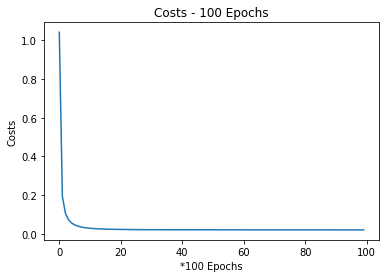

In [30]:
plot_costs_epoch(gaped_costs)

# 4 Conclusion

As displayed above, the result of this model appears to be great.

To summarize my thoughts:

1. How to deal with 30% lost/missing data?
> Firstly separate different types of features, that's because different type of features should be dealt with different methods. 
> - For continuous data, mean value can only cause little displacement of feature distribution(naively thinking...);
> - For ordered Categorical data, mode value represents the common regularity of the feature;
> - For nominal data, filling with -1 means to add an extra possible value into the domain of the feature

2. What to do with selecting hyperparameters?
> Simulating and simplifying skleran-GridCVsearch, go through those posiibilities.

3. Model Structure?
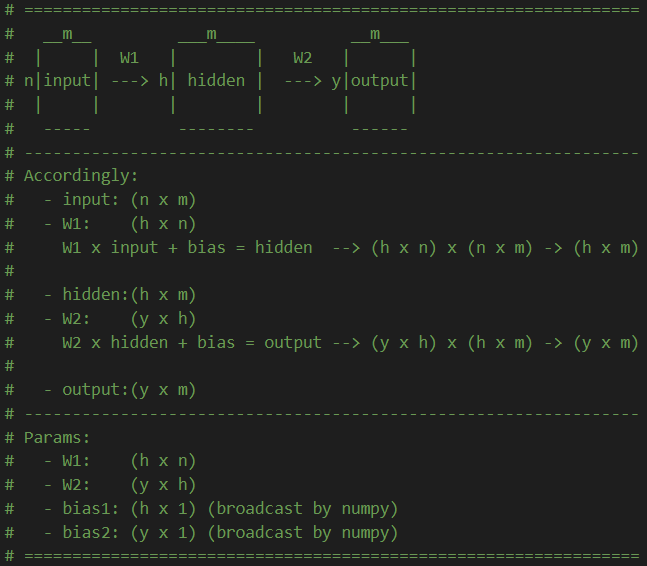
 > For more, refer to module nn(nn.py)